In [1]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json
from mpol import coordinates
from mpol.gridding import DirtyImager

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")


# Observation
data = np.load("../../HD143006_continuum.npz")
u = data["uu"] # klambda units
v = data["vv"]
vis = data["data"]
#wavelength = data["wavelength"]
weight = data["weight"]

# Loading the psf and the dirty image
pixel_scale = 0.0045 # arcsec
npix = 256 # Number of pixels in the grid
coords = coordinates.GridCoords(cell_size=pixel_scale, npix=npix)
img_size = 256 # Number of pixels in the reconstructed image

channel = 7


# imgs = []
# beams =[]
# for channel in range(8):
#     imager = DirtyImager(
#         coords=coords,
#         uu=u,
#         vv=v,
#         weight=weight,
#         data_re=vis_real[channel],
#         data_im=vis_imag[channel]
#     )
#     dirty_image, beam = imager.get_dirty_image(weighting="briggs", robust=0)
#     imgs.append(dirty_image)
#     beams.append(beam)

imager = DirtyImager(
    coords=coords,
    uu=u,
    vv=v,
    weight=weight,
    data_re=vis.real,
    data_im=vis.imag
)

robust = 0.2
dirty_image, beam = imager.get_dirty_image(weighting="briggs", robust=robust)
dirty_image, beam = torch.tensor(dirty_image.copy()).to(device), torch.tensor(beam.copy()).to(device)
# imgs.append(dirty_image)
# beams.append(beam)

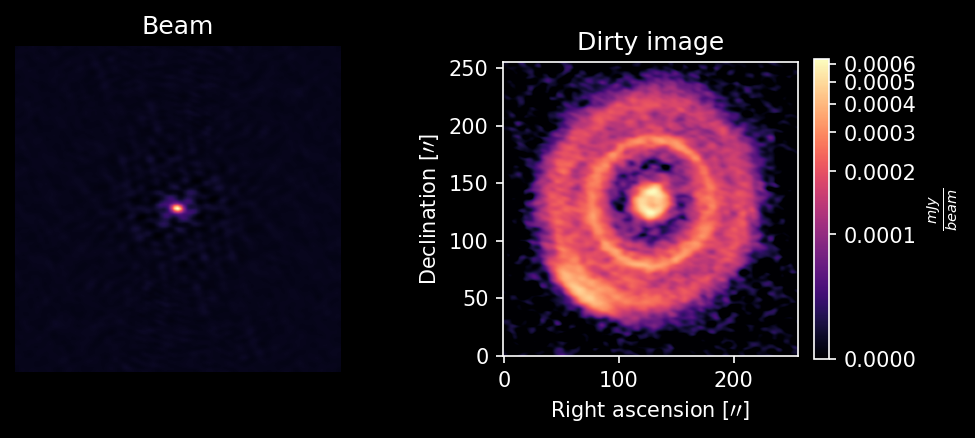

In [32]:
# Plotting... 
fig, axs = plt.subplots(nrows= 1 , ncols = 2, figsize = (7, 3.5))
axs[0].axis("off")

axs[0].imshow(beam.squeeze().real.cpu(), cmap = "magma", origin = "lower")
axs[0].set_title("Beam")

norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
center = int(npix//2)
ext_pix = int(img_size//2)
im = axs[1].imshow((dirty_image).squeeze()[center-ext_pix:center+ext_pix, center-ext_pix:center+ext_pix].real.cpu(), cmap =  "magma", norm = norm, origin = "lower")
axs[1].set(title = "Dirty image", xlabel = r"Right ascension $[\prime\prime]$", ylabel = r"Declination $[\prime\prime]$")
plt.colorbar(im, fraction = 0.046, label = r"$\frac{mJy}{beam}$")
plt.subplots_adjust(wspace = 0.5)

In [193]:
(dirty_image).squeeze()[512-400:512 + 400, 512-400:512+400].shape

torch.Size([800, 800])

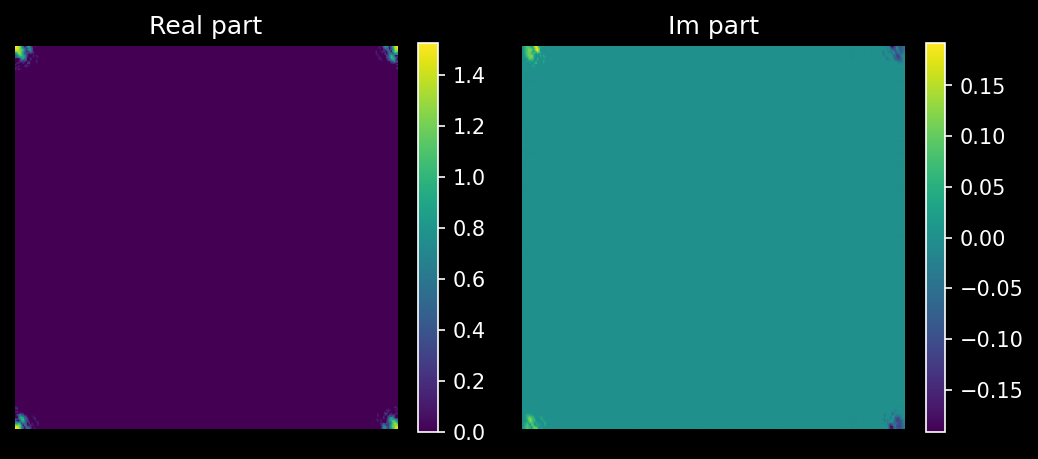

In [57]:
# Sampling function visualization: 
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 2, figsize = (8, 4 ))
im = axs[0].imshow(sampling_function.reshape(img_size, img_size).real.cpu())
plt.colorbar(im, fraction = 0.046)
axs[0].set(title = "Real part")

im = axs[1].imshow(sampling_function.reshape(img_size, img_size).imag.cpu())
plt.colorbar(im, fraction = 0.046)
axs[1].set(title = "Im part")

plt.subplots_adjust(wspace = 0.2)


for i in range(len(axs)): 
    axs[i].axis("off")

In [33]:
bin_x = coords.u_edges
bin_y = coords.v_edges
std_bin_real, edgex, edgey, binumber = binned_statistic_2d(u, v, vis.real, "std", (bin_x, bin_y))
std_bin_imag, edgex, edgey, binumber = binned_statistic_2d(u, v, vis.imag,  "std", (bin_x, bin_y))
  
count, *_ = binned_statistic_2d(u, v, vis.real, "count", (bin_x, bin_y))
count.shape

std_real = (std_bin_real / (count + 1))
std_imag = (std_bin_imag / (count + 1))

std_bin_real[np.isnan(std_bin_real)] = 0
std_bin_imag[np.isnan(std_bin_imag)] = 0

std_bin_real = torch.fft.fftshift(torch.tensor(std_bin_real)).to(device)
std_bin_imag = torch.fft.fftshift(torch.tensor(std_bin_imag)).to(device)

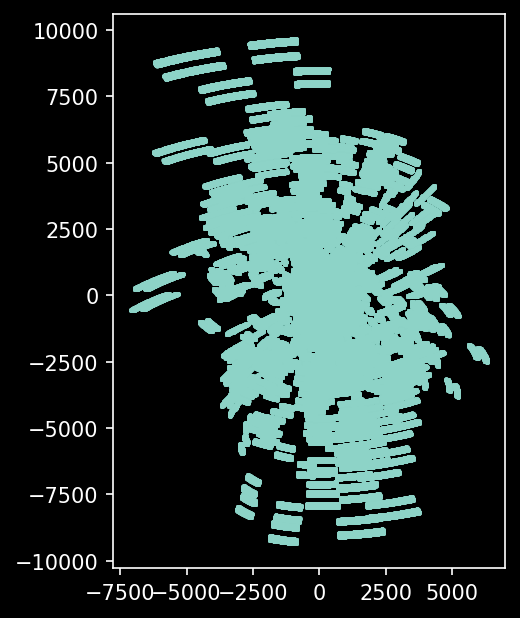

In [54]:
plt.scatter(u, v, s = 1.5, rasterized = True)
plt.gca().set_aspect("equal")

In [126]:
sampling_function = torch.tensor(count>0).to(torch.bool)
S2 = torch.fft.fftshift(sampling_function).flatten().to(device)
# mask = torch.where(sampling_function == 0)
# sampling_function[mask] = 1e-12

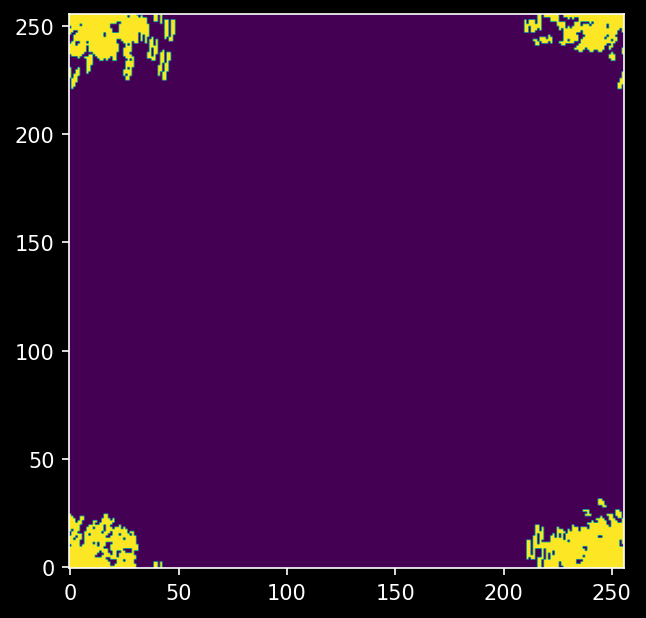

In [101]:
plt.imshow(S.reshape(img_size, img_size).cpu(), origin = "lower")

In [42]:

vis_gridded= ft(dirty_image).flatten()/dirty_image.max()

# Creating the sampling function: 
S = std_bin_real.flatten().to(torch.bool)
vis_gridded = vis_gridded[S]
y = torch.cat([vis_gridded.real, vis_gridded.imag])
D = len(y)


sigma_y = torch.cat([std_bin_real.flatten()[S], std_bin_imag.flatten()[S]])
#sigma_y = torch.tensor(weight).to(device) ** (-0.5)

In [43]:
#sigma_y = 1e-2 * torch.ones(D).to(device)
#beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function(x) # map from model unit space to real unit space

    # Padding: 
    pad_size = int((npix - img_size)/2)
    x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size)) 
    vis_full = ft(x).flatten() 
    vis_sampled = vis_full[S]
    return torch.cat([vis_sampled.real, vis_sampled.imag])


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x)
    var = sigma(t) **2 / 2 + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(x, t): 
    x = x.flatten(start_dim = 1) 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 

tensor(0.0015, device='cuda:0')
tensor([[-5.8024e-03,  1.3609e-04, -1.4141e-03,  ..., -2.2804e-03,
         -4.9270e-05, -1.2953e-03]], device='cuda:0', grad_fn=<AddBackward0>)


In [12]:
vis_gridded.imag.max()

tensor(0.5899, device='cuda:0', dtype=torch.float64)

In [85]:
sampling_function

tensor([1.5263+0.0000j, 1.4985+0.0368j, 1.4001+0.0688j,  ...,
        1.1979-0.0884j, 1.4055-0.0690j, 1.4731-0.0362j], device='cuda:0',
       dtype=torch.complex128)

In [44]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean) 

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 4, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [01:48<00:00,  4.62it/s]


False


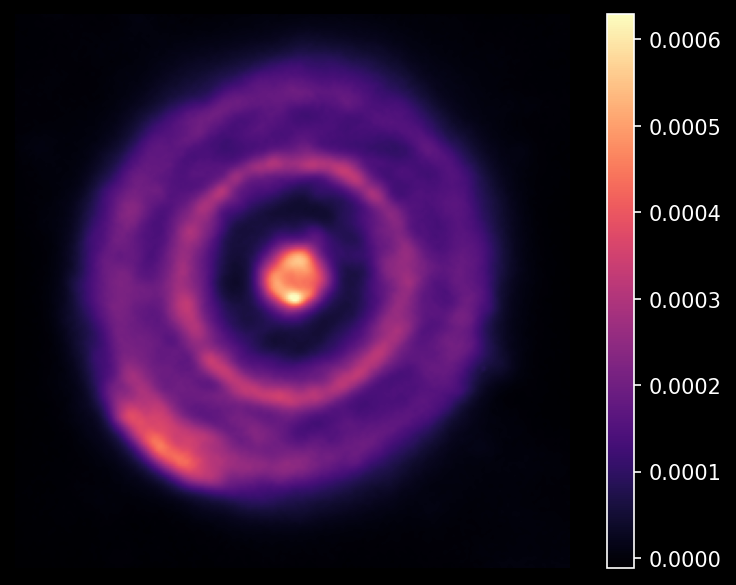

In [45]:

norm = False
save = False
n_images = len(samples)
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HD143006_pad{npix}_robust{robust:.1f}norm.jpeg"
        norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HD143006_pad{npix}_robust{robust:.1f}nonorm.jpeg"
        norm = None
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [16]:
robust = 0.0
f"{robust:.1f}"

'0.0'

In [57]:
I = torch.ones(D).to(device)

In [61]:
S.shape

torch.Size([1, 512, 512])

In [58]:
D

262144